<a href="https://colab.research.google.com/github/Carmen-GL/repo_master_/blob/main/Datathonianos_script_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Importación de librerías**

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
!pip install holidays-es
from holidays_es import get_provinces, Province
import datetime
from sklearn.preprocessing import MinMaxScaler
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#Fijamos semilla aleatoria por reproducibilidad
np.random.seed(7)

In [3]:
use_cuda = torch.cuda.is_available()

#**2. Carga de los datos**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/Modelar_UH2022.txt'
data = pd.read_csv(path, sep='|', header=0, index_col=False)
data.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0


In [6]:
data.shape

(21404828, 6)

#**2. Visualización de los datos y preprocesado**

In [7]:
data.dtypes

ID                     int64
SAMPLETIME            object
READINGINTEGER         int64
READINGTHOUSANDTH    float64
DELTAINTEGER           int64
DELTATHOUSANDTH      float64
dtype: object

In [8]:
#Convertimos la fecha y hora de string a formato de fecha de pandas
data['SAMPLETIME'] = pd.to_datetime(data['SAMPLETIME'], format='%Y-%m-%d %H:%M:%S', utc=True)

In [9]:
data.dtypes

ID                                 int64
SAMPLETIME           datetime64[ns, UTC]
READINGINTEGER                     int64
READINGTHOUSANDTH                float64
DELTAINTEGER                       int64
DELTATHOUSANDTH                  float64
dtype: object

In [10]:
contadores = data['ID'].unique()
contadores

array([   0,    1,    2, ..., 2748, 2749, 2756])

In [11]:
      #Extraemos mes y año
data['YEAR'] = data['SAMPLETIME'].dt.year
data['MONTH'] = data['SAMPLETIME'].dt.month
data['DAY'] = data['SAMPLETIME'].dt.day
data['DAY_WEEK'] = data["SAMPLETIME"].dt.dayofweek
data['HOURS'] = data["SAMPLETIME"].dt.time

In [12]:
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,DAY_WEEK,HOURS
0,0,2019-06-13 08:34:09+00:00,369320,0.0,17,0.0,2019,6,13,3,08:34:09
1,0,2019-06-13 17:34:10+00:00,369403,0.0,2,0.0,2019,6,13,3,17:34:10
2,0,2019-06-13 18:34:10+00:00,369403,0.0,0,0.0,2019,6,13,3,18:34:10
3,0,2019-06-13 04:34:10+00:00,369284,0.0,1,0.0,2019,6,13,3,04:34:10
4,0,2019-06-13 14:34:10+00:00,369356,0.0,28,0.0,2019,6,13,3,14:34:10


In [13]:
reading_sum = data["READINGINTEGER"] + data["READINGTHOUSANDTH"]
data["READING_TOTAL"] = reading_sum

delta_sum = data["DELTAINTEGER"] + data["DELTATHOUSANDTH"]
data["DELTA_TOTAL"] = delta_sum

print(data)

            ID                SAMPLETIME  READINGINTEGER  READINGTHOUSANDTH  \
0            0 2019-06-13 08:34:09+00:00          369320                0.0   
1            0 2019-06-13 17:34:10+00:00          369403                0.0   
2            0 2019-06-13 18:34:10+00:00          369403                0.0   
3            0 2019-06-13 04:34:10+00:00          369284                0.0   
4            0 2019-06-13 14:34:10+00:00          369356                0.0   
...        ...                       ...             ...                ...   
21404823  2749 2019-10-11 06:27:14+00:00          164505                0.0   
21404824  2756 2019-04-06 05:50:17+00:00          349758                0.0   
21404825  2756 2019-04-06 07:50:17+00:00          349770                0.0   
21404826  2756 2019-04-06 04:50:17+00:00          349758                0.0   
21404827  2756 2019-04-06 06:50:17+00:00          349758                0.0   

          DELTAINTEGER  DELTATHOUSANDTH  YEAR  MONT

In [14]:
data.sort_values(['ID', 'YEAR',	'MONTH',	'DAY', 'HOURS'], ascending = (True, True, True, True, True))

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,DAY_WEEK,HOURS,READING_TOTAL,DELTA_TOTAL
160,0,2019-02-01 00:39:36+00:00,331710,0.0,0,0.0,2019,2,1,4,00:39:36,331710.0,0.0
152,0,2019-02-01 01:39:36+00:00,331710,0.0,0,0.0,2019,2,1,4,01:39:36,331710.0,0.0
150,0,2019-02-01 02:39:35+00:00,331710,0.0,0,0.0,2019,2,1,4,02:39:35,331710.0,0.0
156,0,2019-02-01 03:39:35+00:00,331710,0.0,0,0.0,2019,2,1,4,03:39:35,331710.0,0.0
161,0,2019-02-01 04:39:35+00:00,331710,0.0,0,0.0,2019,2,1,4,04:39:35,331710.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21404822,2749,2019-10-11 07:27:14+00:00,164507,0.0,2,0.0,2019,10,11,4,07:27:14,164507.0,2.0
21404826,2756,2019-04-06 04:50:17+00:00,349758,0.0,0,0.0,2019,4,6,5,04:50:17,349758.0,0.0
21404824,2756,2019-04-06 05:50:17+00:00,349758,0.0,0,0.0,2019,4,6,5,05:50:17,349758.0,0.0
21404827,2756,2019-04-06 06:50:17+00:00,349758,0.0,0,0.0,2019,4,6,5,06:50:17,349758.0,0.0


In [15]:
data['DATE'] = data["SAMPLETIME"].dt.date

In [17]:
data['SEASON'] = data["SAMPLETIME"].dt.quarter
data

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,DAY_WEEK,HOURS,READING_TOTAL,DELTA_TOTAL,DATE,SEASON
0,0,2019-06-13 08:34:09+00:00,369320,0.0,17,0.0,2019,6,13,3,08:34:09,369320.0,17.0,2019-06-13,2
1,0,2019-06-13 17:34:10+00:00,369403,0.0,2,0.0,2019,6,13,3,17:34:10,369403.0,2.0,2019-06-13,2
2,0,2019-06-13 18:34:10+00:00,369403,0.0,0,0.0,2019,6,13,3,18:34:10,369403.0,0.0,2019-06-13,2
3,0,2019-06-13 04:34:10+00:00,369284,0.0,1,0.0,2019,6,13,3,04:34:10,369284.0,1.0,2019-06-13,2
4,0,2019-06-13 14:34:10+00:00,369356,0.0,28,0.0,2019,6,13,3,14:34:10,369356.0,28.0,2019-06-13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21404823,2749,2019-10-11 06:27:14+00:00,164505,0.0,0,0.0,2019,10,11,4,06:27:14,164505.0,0.0,2019-10-11,4
21404824,2756,2019-04-06 05:50:17+00:00,349758,0.0,0,0.0,2019,4,6,5,05:50:17,349758.0,0.0,2019-04-06,2
21404825,2756,2019-04-06 07:50:17+00:00,349770,0.0,12,0.0,2019,4,6,5,07:50:17,349770.0,12.0,2019-04-06,2
21404826,2756,2019-04-06 04:50:17+00:00,349758,0.0,0,0.0,2019,4,6,5,04:50:17,349758.0,0.0,2019-04-06,2


In [ ]:
# create us_holidays object
holidays_20 = Province(name="valencia", year=2020).holidays()
holidays_20 = holidays_20['national_holidays']

holidays_19 = Province(name="valencia", year=2019).holidays()
holidays_19 = holidays_19['national_holidays']

holidays_list = []

for index, row in data.iterrows(): 
  if row['DATE'] in holidays_20:
    holidays_list.append(1)
  elif row['DATE'] in holidays_19:
    holidays_list.append(1)
  else:
    holidays_list.append(0)

print(len(holidays_list))

data['HOLIDAYS'] = holidays_list
data

In [1]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.hist(x=data['SEASON'],bins=10)
plt.title('Histogram of Seasons')



NameError: ignored

<Figure size 576x576 with 0 Axes>

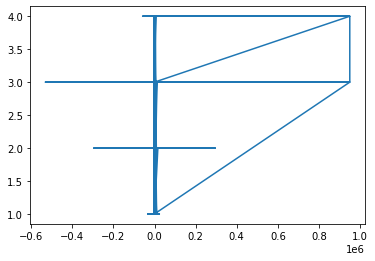

<Figure size 576x576 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(8,8))

ax.plot(data['SEASON'],data['DELTA_TOTAL'])

plt.show()

In [22]:
date      = data['DATE'].values
year        = data["YEAR"].values
month         = data['MONTH'].values
season      = data['SEASON'].values
day_of_week = data['DAY_WEEK'].values
#No nos interesa tener una variable semana (posición que ocupa la semana dentro del mes) porque el agua es un bien de primera
#necesidad y no se suele consumir más o menos en función de si se tiene mayor o menor presupuesto

KeyError: ignored

In [ ]:
#Normalización de la variable a predecir

target = np.reshape(data["DELTA_TOTAL"].values, (-1,1)) #variable endógena, convertimos en array y damos forma a los datos porque tienen una sola feature
min_max_scaler = MinMaxScaler()
target_scaled = min_max_scaler.fit_transform(target)
print(target_scaled)
#transformamos a tensor
target_scaled = torch.FloatTensor(target_scaled).view(-1)
target_scaled

[[0.35843632]
 [0.35842619]
 [0.35842484]
 ...
 [0.35843295]
 [0.35842484]
 [0.35842484]]


tensor([0.3584, 0.3584, 0.3584,  ..., 0.3584, 0.3584, 0.3584])

In [18]:
data.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,READING_TOTAL,DELTA_TOTAL,DAY_WEEK
count,2.140483e+07,2.140483e+07,2.126477e+07,2.140483e+07,2.126477e+07,2.140483e+07,2.140483e+07,2.140483e+07,2.126477e+07,2.126477e+07,2.140483e+07
mean,1.259029e+03,6.052178e+05,3.930737e+00,2.277017e+01,4.228367e+00,2.019091e+03,6.611014e+00,1.576177e+01,4.342128e+05,2.436699e+01,3.001770e+00
std,7.334956e+02,2.857464e+06,1.496893e+01,1.516794e+03,1.541059e+01,2.877560e-01,3.484846e+00,8.798255e+00,1.865854e+06,1.519755e+03,1.997277e+00
min,0.000000e+00,-6.407800e+04,0.000000e+00,-5.307340e+05,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,-6.407800e+04,-5.307340e+05,0.000000e+00
25%,6.230000e+02,6.368800e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,4.000000e+00,8.000000e+00,6.297800e+04,0.000000e+00,1.000000e+00
50%,1.255000e+03,1.831570e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,7.000000e+00,1.600000e+01,1.815200e+05,0.000000e+00,3.000000e+00
75%,1.887000e+03,3.520500e+05,0.000000e+00,9.000000e+00,0.000000e+00,2.019000e+03,1.000000e+01,2.300000e+01,3.468610e+05,1.400000e+01,5.000000e+00
max,2.756000e+03,5.108976e+07,9.900000e+01,9.499810e+05,9.900000e+01,2.020000e+03,1.200000e+01,3.100000e+01,5.108976e+07,9.500060e+05,6.000000e+00


In [21]:
print(data['YEAR'].min())

2019
